# Titanic competition

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import polars as pl
import matplotlib.pyplot as plt
import plotly.express as px

plt.rcParams['figure.figsize'] = (20, 10)
import plotly.graph_objects as go

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('./kaggle/input'):
    print(dirname)
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

./kaggle/input
./kaggle/input\gender_submission.csv
./kaggle/input\test.csv
./kaggle/input\test_sampled.csv
./kaggle/input\titanic.zip
./kaggle/input\train.csv
./kaggle/input\train_sampled.csv


In [3]:
import glob
from sklearn.model_selection import train_test_split

df = pl.read_csv('./kaggle/input/train.csv')
splits = train_test_split(df, test_size=0.25, random_state=0, shuffle=True, stratify=df.select("Survived"),)
train: pl.DataFrame = splits[0]
test: pl.DataFrame = splits[1]

if len(glob.glob('**/train_sampled.csv', recursive=True)) == 0:
    train.write_csv('./kaggle/input/train_sampled.csv')
    test.write_csv('./kaggle/input/test_sampled.csv')

In [4]:
train.shape

e


In [5]:
train.describe()

describe,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
str,f64,f64,f64,str,str,f64,f64,f64,str,f64,str,str
"""count""",668.0,668.0,668.0,"""668""","""668""",668.0,668.0,668.0,"""668""",668.0,"""668""","""668"""
"""null_count""",0.0,0.0,0.0,"""0""","""0""",136.0,0.0,0.0,"""0""",0.0,"""515""","""2"""
"""mean""",444.244012,0.383234,2.299401,null,null,29.796842,0.502994,0.363772,null,33.273328,null,null
"""std""",260.923752,0.486539,0.841324,null,null,14.477953,1.061098,0.7846,null,53.472183,null,null
"""min""",2.0,0.0,1.0,"""Abbott, Mr. Ro…","""female""",0.42,0.0,0.0,"""110152""",0.0,"""A10""","""C"""
"""max""",891.0,1.0,3.0,"""van Melkebeke,…","""male""",80.0,8.0,6.0,"""WE/P 5735""",512.3292,"""T""","""S"""
"""median""",444.5,0.0,3.0,null,null,29.0,0.0,0.0,null,14.4542,null,null
"""25%""",218.0,0.0,2.0,null,null,20.0,0.0,0.0,null,7.925,null,null
"""75%""",676.0,1.0,3.0,null,null,38.0,1.0,0.0,null,30.5,null,null


In [6]:
train.head()

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
i64,i64,i64,str,str,f64,i64,i64,str,f64,str,str
672,0,1,"""Davidson, Mr. …","""male""",31.0,1,0,"""F.C. 12750""",52.0,"""B71""","""S"""
418,1,2,"""Silven, Miss. …","""female""",18.0,0,2,"""250652""",13.0,null,"""S"""
635,0,3,"""Skoog, Miss. M…","""female""",9.0,3,2,"""347088""",27.9,null,"""S"""
324,1,2,"""Caldwell, Mrs.…","""female""",22.0,1,1,"""248738""",29.0,null,"""S"""
380,0,3,"""Gustafsson, Mr…","""male""",19.0,0,0,"""347069""",7.775,null,"""S"""


# The goal of this part is to make the simplest and straightforward model to get a baseline.

let's use a logistic regression with a simple pipeline.

In [55]:
import mlflow
from mlflow import log_metric 
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import  StandardScaler, OneHotEncoder
from sklearn.compose import  make_column_transformer, make_column_selector
from feature_engine.imputation import MeanMedianImputer
from feature_engine.selection import DropFeatures
from feature_engine.encoding import OneHotEncoder
from feature_engine.imputation import CategoricalImputer

with mlflow.start_run(run_name='titanic classification') as run:
    # enable autologging
    mlflow.sklearn.autolog()

    X = train.select(pl.exclude("Survived")).to_pandas()
    y: pl.DataFrame = train.select(pl.col("Survived")).to_pandas()
    X_test = test.select(pl.exclude("Survived")).to_pandas()
    y_test = test.select(pl.col("Survived")).to_pandas()

    # Dropping features that needs more work to be used
    pipe = make_pipeline(
        DropFeatures(['Cabin', 'PassengerId', 'Name', "Ticket"]), 
        CategoricalImputer(), 
        MeanMedianImputer(), 
        make_column_transformer(
            (StandardScaler(),
            make_column_selector(dtype_include=np.number)),
            (OneHotEncoder(), make_column_selector(dtype_include=object)),
            sparse_threshold = 0), 
        LogisticRegression(),
        )

    pipe.fit(X, y)
    predictions = pipe.predict(X)

    log_metric("testing_accuracy_score", float(pipe.score(X_test, y_test)))

    print("Run ID: {} experiment ID: {}".format(run.info.run_id, run.info.experiment_id))

2023/09/03 02:36:06 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('dropfeatures', DropFeatures(features_to_drop=['Cabin', 'PassengerId', 'Name', 'Ticket'])), ('categoricalimputer', CategoricalImputer()), ('meanmedianimputer', MeanMedianImputer()), ('columntransformer', ColumnTransformer(sparse_threshold=0,
                  transformers=[('standardscaler', StandardScaler(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000022E4216B410>),
                                ('onehotencoder', OneHotEncod...`
2023/09/03 02:36:06 WARNING mlflow.data.pandas_dataset: Failed to infer schema for Pandas dataset. Exception: Unable to map 'object' type to MLflow DataType. object can be mapped iff all values have identical data type which is one of (string, (bytes or byterray),  int, float).
c:\Users\gaetd\AppData\Local\pypoetry\Cache\virtualenvs\kaggle-titanic-5fA9pY_j-py3.11\Lib\site-packages\sklearn\utils\

Run ID: c00c28063cd945b4a0f50da46989b59c experiment ID: 0


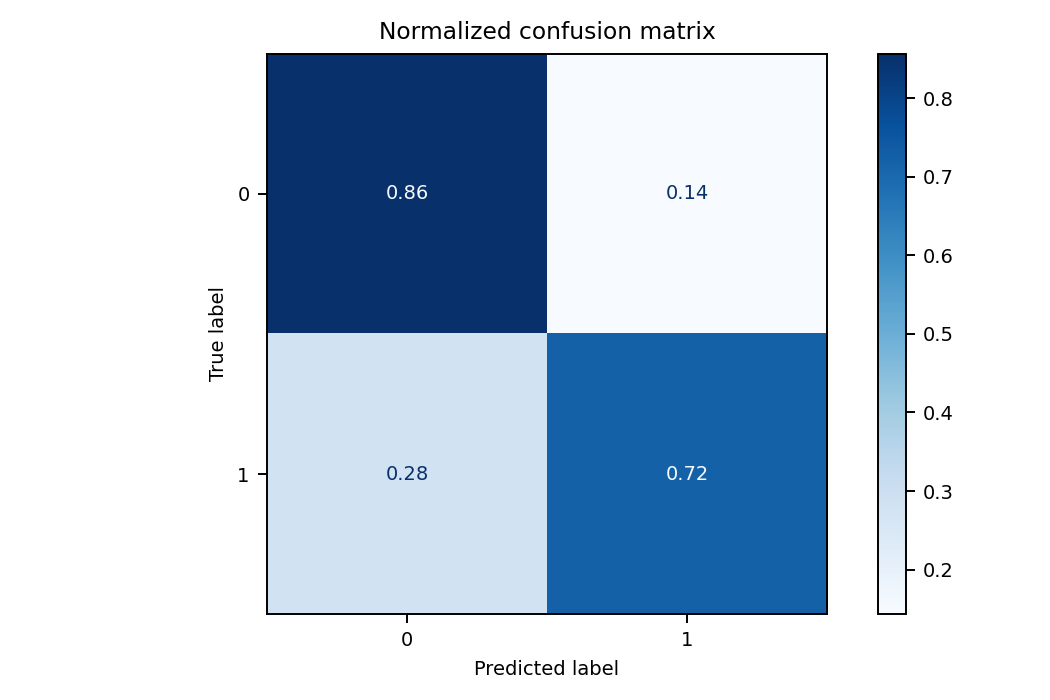

In [56]:
from mlflow import MlflowClient
from mlflow.entities import ViewType

run = MlflowClient().search_runs(
    experiment_ids="0",
    filter_string="",
    run_view_type=ViewType.ALL,
    order_by=["metrics.testing_accuracy_score DESC"],
)[0]

def fetch_logged_data(run_id):
    client = MlflowClient()
    data = client.get_run(run_id).data
    tags = {k: v for k, v in data.tags.items() if not k.startswith("mlflow.")}
    artifacts = [f.path for f in client.list_artifacts(run_id, "model")]
    return data.params, data.metrics, tags, artifacts

params, metrics, tags, artifacts = fetch_logged_data(run.info.run_id)

from IPython.display import Image
Image(mlflow.artifacts.download_artifacts(run_id=run.info.run_id, artifact_path="training_confusion_matrix.png"))

# Submission

In [66]:
logged_model = mlflow.artifacts.download_artifacts(run_id=run.info.run_id, artifact_path="model")

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

test = pl.read_csv('./kaggle/input/test.csv').to_pandas()
results = loaded_model.predict(test)

import pandas as pd
pd.concat([test.PassengerId, pd.Series(results, name="Survived")], axis=1).to_csv('submission.csv', index=False)

Then run this command `kaggle competitions submit -c titanic -f submission.csv -m "MLflow and logistic regressor"`

# Let's improve the model

In [41]:
df_cabin_prefix = train.with_columns(pl.col("Cabin").str.replace("\d+", "", n=-1).apply(lambda x: x[0]).alias("Cabin_prefix"))
fig = px.box(df_cabin_prefix.sort("Cabin_prefix"), x="Fare", y="Cabin_prefix", color="Cabin_prefix")
fig.show()

In [72]:
df_cabin_prefix

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_prefix
i64,i64,i64,str,str,f64,i64,i64,str,f64,str,str,str
672,0,1,"""Davidson, Mr. …","""male""",31.0,1,0,"""F.C. 12750""",52.0,"""B71""","""S""","""B"""
418,1,2,"""Silven, Miss. …","""female""",18.0,0,2,"""250652""",13.0,null,"""S""",null
635,0,3,"""Skoog, Miss. M…","""female""",9.0,3,2,"""347088""",27.9,null,"""S""",null
324,1,2,"""Caldwell, Mrs.…","""female""",22.0,1,1,"""248738""",29.0,null,"""S""",null
380,0,3,"""Gustafsson, Mr…","""male""",19.0,0,0,"""347069""",7.775,null,"""S""",null
251,0,3,"""Reed, Mr. Jame…","""male""",null,0,0,"""362316""",7.25,null,"""S""",null
652,1,2,"""Doling, Miss. …","""female""",18.0,0,1,"""231919""",23.0,null,"""S""",null
75,1,3,"""Bing, Mr. Lee""","""male""",32.0,0,0,"""1601""",56.4958,null,"""S""",null
219,1,1,"""Bazzani, Miss.…","""female""",32.0,0,0,"""11813""",76.2917,"""D15""","""C""","""D"""


In [26]:
fig = px.box(train, x="Fare", y="Embarked", color="Embarked")
fig.show()

In [44]:
df = train.groupby("Embarked").agg(pl.col("Survived").sum()/pl.col("Survived").count(), pl.col("Fare").mean()).filter(pl.col("Embarked").is_not_null())
fig = px.bar(df, x="Embarked", y="Survived", color="Embarked", orientation="v")
fig.show()

In [66]:
import plotly.express as px
df = df_cabin_prefix.groupby("Cabin_prefix").agg(
    pl.col("Survived").sum()/pl.col("Survived").count().alias("count_survived"),
    pl.col("Pclass").filter(pl.col("Pclass") == 1).count().alias("class 1"),
    pl.col("Pclass").filter(pl.col("Pclass") == 2).count().alias("class 2"),
    pl.col("Pclass").filter(pl.col("Pclass") == 3).count().alias("class 3"),
    pl.col("Fare").mean(),
    ).filter(pl.col("Cabin_prefix") != "nan").pivot(index=["Cabin_prefix"], columns=["Pclass"], values="count_survived").to_pandas()
fig = px.bar(df.sort("Cabin_prefix"), x="Cabin_prefix", y="Survived", color="Cabin_prefix", orientation="v")
fig.show()

In [86]:
df_cabin_prefix.groupby("Pclass", "Cabin_prefix").agg(
    pl.col("Survived").sum().alias("count_survived"),
    pl.col("Pclass").count().alias("count_total"),
    pl.col("Fare").mean(),
    ).filter(pl.col("Cabin_prefix") != "nan")

Pclass,Cabin_prefix,count_survived,count_total,Fare
i64,str,i64,u32,f64
2,"""D""",2,3,12.958333
1,"""T""",0,1,35.5
3,"""F""",0,2,7.65
1,"""B""",31,43,118.31977
2,"""E""",3,4,11.5875
1,"""D""",17,24,62.565629
1,"""C""",27,45,97.551387
3,"""G""",1,3,12.541667
2,"""F""",4,4,21.5


c:\Users\gaetd\AppData\Local\pypoetry\Cache\virtualenvs\kaggle-titanic-xNW5dI96-py3.11\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning:

The figure layout has changed to tight



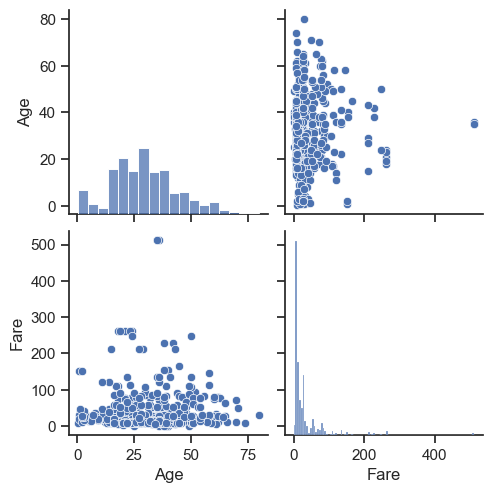

In [60]:
import seaborn as sns
sns.set_theme(style="ticks")

sns.pairplot(train.select("Age", "Fare").to_pandas())